# Simple Forecast

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.model_selection import TimeSeriesSplit
from prophet import Prophet

<IPython.core.display.Javascript object>

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
plt.rcParams["figure.figsize"] = (16, 10)

<IPython.core.display.Javascript object>

----------------------------------------

## Read Data

In [4]:
trips = pd.read_csv("../data/trips/daily_trips.csv")
trips.date = pd.to_datetime(trips.date)
trips.rename(columns={"date": "ds", "daily_trips": "y"}, inplace=True)

<IPython.core.display.Javascript object>

In [5]:
trips.head()

,ds,y
0,2011-01-01,959
1,2011-01-02,781
2,2011-01-03,1301
3,2011-01-04,1536
4,2011-01-05,1571


<IPython.core.display.Javascript object>

In [24]:
weather = pd.read_csv("../data/weather/daily_weather.csv")
weather.date = pd.to_datetime(weather.date)
weather.rename(
    columns={
        "date": "ds",
        "Normal_Max_Temp_C": "tmax",
        "Normal_Min_Temp_C": "tmin",
        "Normal_Precipitation_CM": "precip",
    },
    inplace=True,
)

<IPython.core.display.Javascript object>

In [26]:
trips = pd.merge(trips, weather, on="ds", how="left")

<IPython.core.display.Javascript object>

In [27]:
trips.head()

,ds,y,tmax,tmin,precip
0,2011-01-01,959,7.777778,0.000000,0.2286
1,2011-01-02,781,7.222222,-0.555556,0.2286
2,2011-01-03,1301,7.222222,-0.555556,0.2540
3,2011-01-04,1536,7.222222,-0.555556,0.2286
4,2011-01-05,1571,7.222222,-0.555556,0.2540


<IPython.core.display.Javascript object>

In [8]:
holidays = pd.read_csv("../data/holidays/holidays.csv")
holidays.ds = pd.to_datetime(holidays.ds)

<IPython.core.display.Javascript object>

In [9]:
holidays.head()

,ds,holiday,lower_window,upper_window
0,2010-11-25,Thanksgiving,0,1
1,2010-12-25,Christmas Day,-1,0
2,2011-01-01,New Year's Day,-1,0
3,2011-05-30,Memorial Day,0,0
4,2011-07-04,Independence Day,0,0


<IPython.core.display.Javascript object>

## Simple Forecast

Use Prophet to create a simple forecast.  Don't do any tuning, CV, etc, just create a forecast on one training dataset and test the performance on a test dataset

### Train / Test Split

In [37]:
# TODO
train = trips[trips.ds <= '2016-12-31']
test = trips[trips.ds >= '2017-01-01']



<IPython.core.display.Javascript object>

### Fit and Predict

In [92]:
m = Prophet(seasonality_mode="multiplicative")
m.fit(train)
# future = m.make_future_dataframe(periods=365 * 2)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg93xg19l/_2gsef0_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg93xg19l/x6tcpxgn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/allen/anaconda3/lib/python3.7/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94985', 'data', 'file=/tmp/tmpg93xg19l/_2gsef0_.json', 'init=/tmp/tmpg93xg19l/x6tcpxgn.json', 'output', 'file=/tmp/tmpg93xg19l/prophet_modelcdxbr34n/prophet_model-20221024221626.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:16:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:16:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


<IPython.core.display.Javascript object>

In [93]:
forecast = m.predict(trips)

<IPython.core.display.Javascript object>

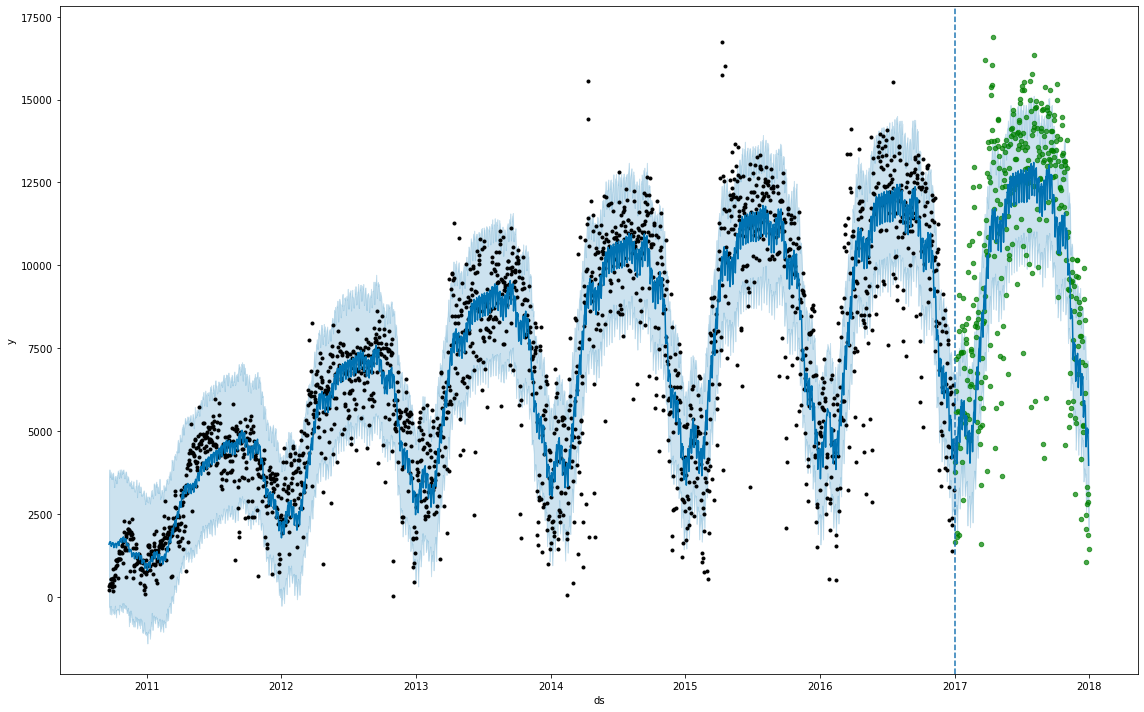

<IPython.core.display.Javascript object>

In [94]:
fig, ax = plt.subplots(1, 1)
m.plot(forecast, ax=ax)
test.plot.scatter(x="ds", y="y", ax=ax, marker="o", color="green", alpha=0.7)

ax.axvline(dt.datetime(2017, 1, 1), linestyle="dashed")
plt.show()

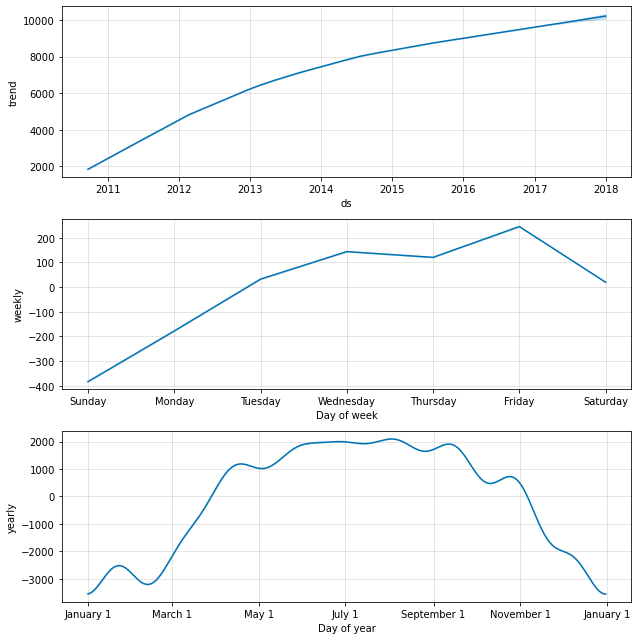

<IPython.core.display.Javascript object>

In [74]:
component_plot = m.plot_components(forecast)

In [90]:
m2 = Prophet(holidays=holidays, seasonality_mode="multiplicative")
m2.fit(train)
forecast2 = m2.predict(trips)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg93xg19l/cazxehvx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg93xg19l/ged5msvz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/allen/anaconda3/lib/python3.7/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80599', 'data', 'file=/tmp/tmpg93xg19l/cazxehvx.json', 'init=/tmp/tmpg93xg19l/ged5msvz.json', 'output', 'file=/tmp/tmpg93xg19l/prophet_modelbkrlojnj/prophet_model-20221024221603.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:16:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:16:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


<IPython.core.display.Javascript object>

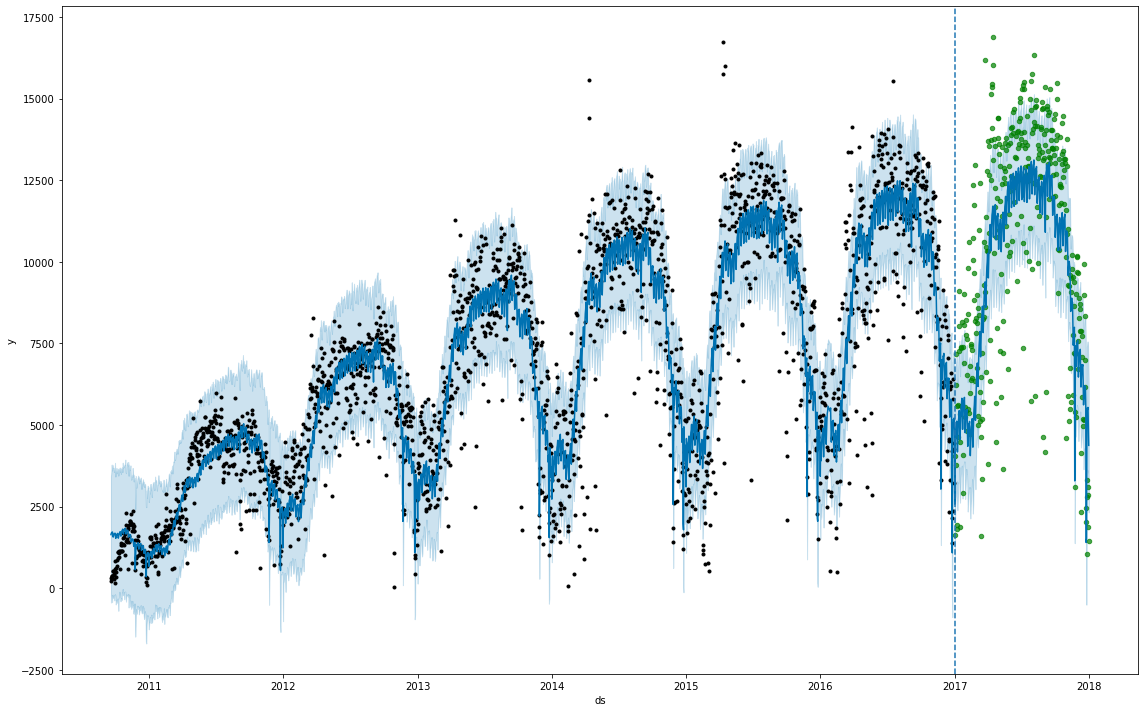

<IPython.core.display.Javascript object>

In [91]:
fig, ax = plt.subplots(1, 1)
plt2 = m2.plot(forecast2, ax=ax)
points = test.plot.scatter(x="ds", y="y", ax=ax, marker="o", color="green", alpha=0.7)
sep_line = ax.axvline(dt.datetime(2017, 1, 1), linestyle="dashed")
plt.show()

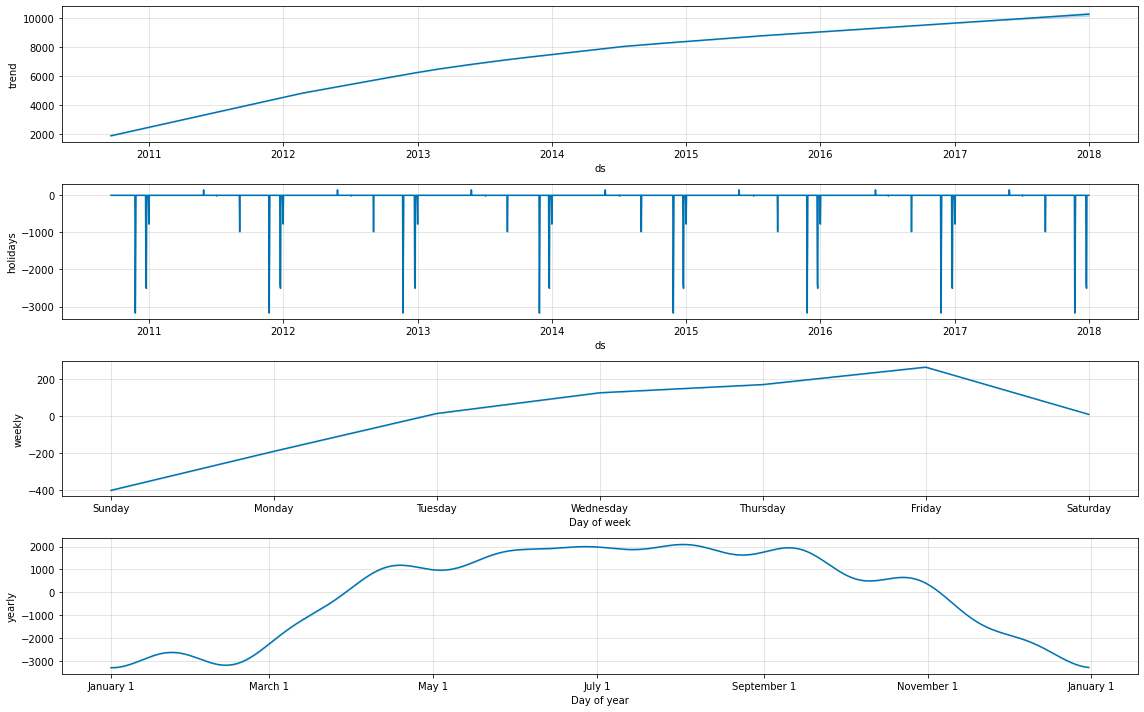

<IPython.core.display.Javascript object>

In [83]:
m2_components = m2.plot_components(forecast2, figsize=(16, 10))

### Add Weather Data

In [115]:
m3 = Prophet(holidays=holidays, seasonality_mode="multiplicative")
m3.add_regressor("tmax")
m3.add_regressor("precip")
m3.fit(trips)
forecast3 = m3.predict(trips)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg93xg19l/w43_3xn9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg93xg19l/lf6goawx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/allen/anaconda3/lib/python3.7/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77856', 'data', 'file=/tmp/tmpg93xg19l/w43_3xn9.json', 'init=/tmp/tmpg93xg19l/lf6goawx.json', 'output', 'file=/tmp/tmpg93xg19l/prophet_modeluzqbvec4/prophet_model-20221024223025.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:30:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:30:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


<IPython.core.display.Javascript object>

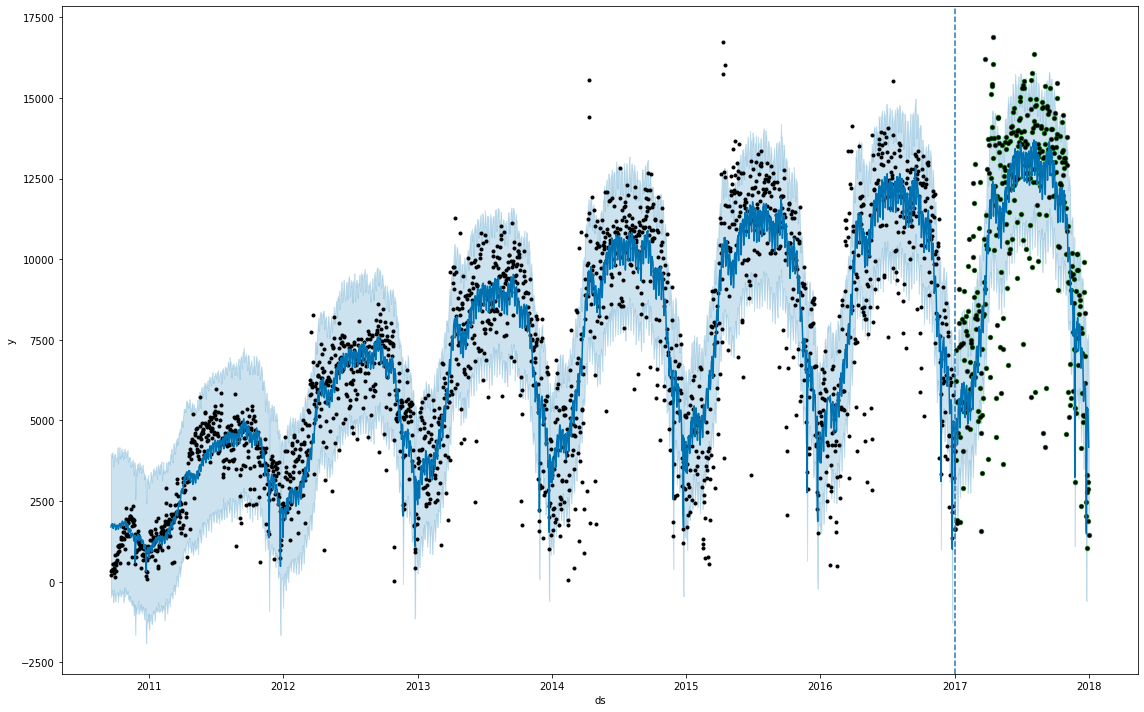

<IPython.core.display.Javascript object>

In [113]:
fig, ax = plt.subplots(1, 1)
plt3 = m3.plot(forecast3, ax=ax)
points = test.plot.scatter(x="ds", y="y", ax=ax, marker="o", color="green", alpha=0.7)
sep_line = ax.axvline(dt.datetime(2017, 1, 1), linestyle="dashed")
plt.show()

In [119]:
foo = forecast3.merge(trips[["ds", "y"]], how="left", on="ds")

<IPython.core.display.Javascript object>

In [121]:
foo["resid"] = foo.y - foo.yhat

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='ds', ylabel='resid'>

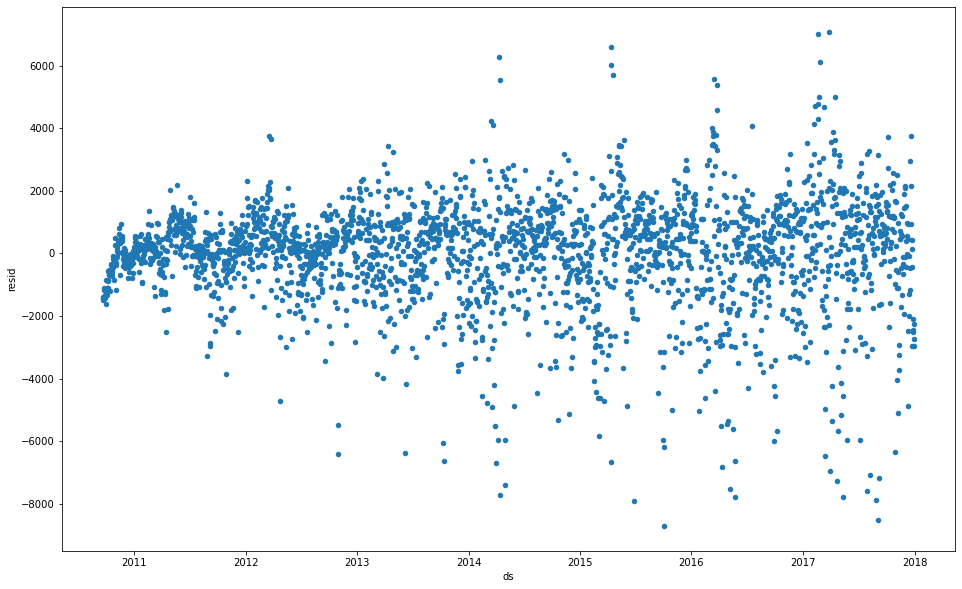

<IPython.core.display.Javascript object>

In [123]:
foo.plot.scatter(x="ds", y="resid")